In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Function to retrieve grid specs

In [26]:
def return_grid_specs(path):
    
    df = pd.read_csv(path)
    col_name = df.columns[0]
    ncols_line = df.columns[0]
    nrows_line = df[col_name][0]
    xmin_line = df[col_name][1]
    ymin_line = df[col_name][2]
    size_line = df[col_name][3]

    x_n = int(ncols_line.split()[-1])
    y_n = int(nrows_line.split()[-1])
    x_min = int(float(xmin_line.split()[-1]))
    y_min = int(float(ymin_line.split()[-1]))
    cell_size = int(float(size_line.split()[-1]))

    x = np.arange(x_min, x_min + cell_size * x_n, cell_size) / 1000
    y = np.arange(y_min, y_min + cell_size * y_n, cell_size) / 1000

    return x, y

# Get data

In [27]:
# Load arrays
timestamp = "198001010200"
wn_in_path = "/scratch/summit/erke2265/windninja/PIG/" + timestamp + "/input/" + timestamp + "_vel.asc"
wn_out_path = "/scratch/summit/erke2265/windninja/PIG/" + timestamp + "/output/PIG_1000m_vel.asc"

wn_in = np.loadtxt(wn_in_path, skiprows=6)
wn_out = np.loadtxt(wn_out_path, skiprows=6)

# Find max min
maxima = np.maximum(wn_in.max(), wn_out.max())
minima = np.minimum(wn_in.min(), wn_out.min())
print("Maxima = " + str(maxima))
print("Minima = " + str(minima))

Maxima = 9.432000160217285
Minima = 5.625999927520752


# Input files

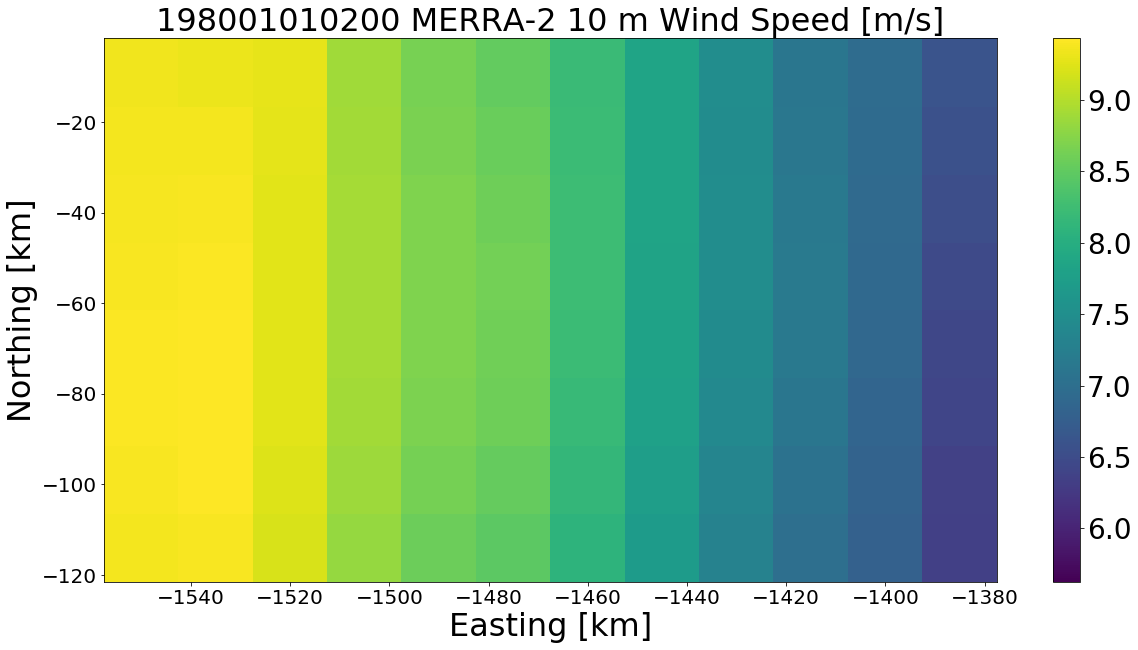

In [28]:
x, y = return_grid_specs(wn_in_path)

plt.figure(figsize=(20, 10))
plt.pcolor(x, y, wn_in, vmin=minima, vmax=maxima)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(timestamp + " MERRA-2 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/M2_wind_speed.pdf", dpi=100)

# Output files

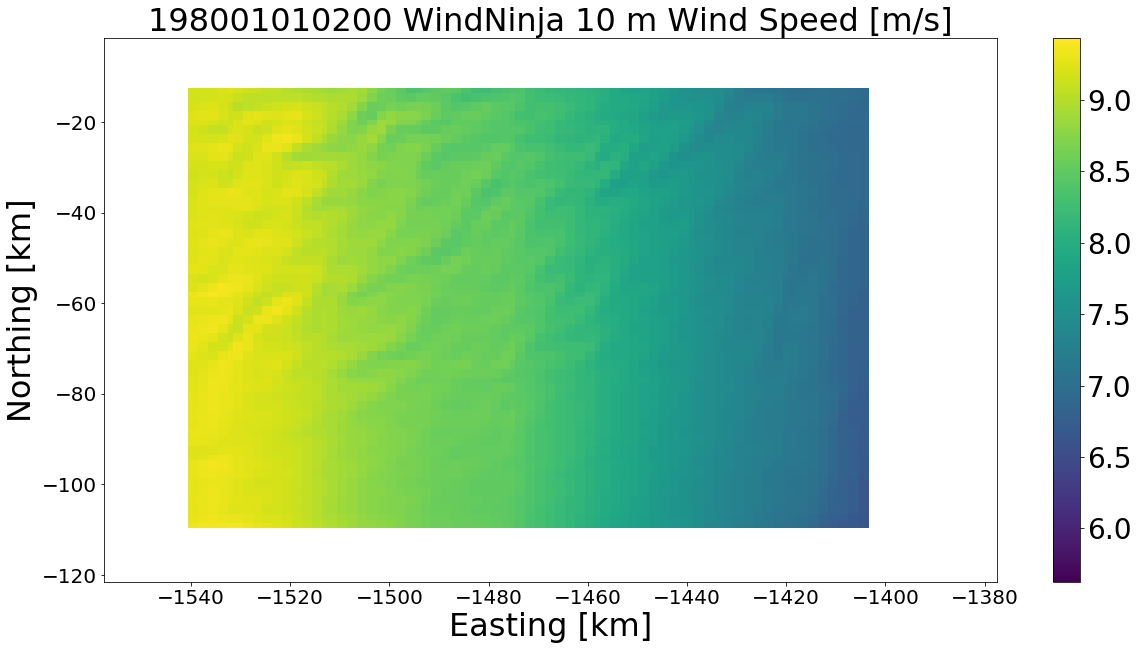

In [29]:
wn_x, wn_y = return_grid_specs(wn_out_path)

plt.figure(figsize=(20, 10))
plt.pcolor(wn_x, wn_y, wn_out, vmin=minima, vmax=maxima)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xlim([x.min(), x.max()])
plt.ylim([y.min(), y.max()])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(timestamp + " WindNinja 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/WN_wind_speed.pdf", dpi=100)